<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('spanish'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Levantamos los datos
!rm Correos_Seleccionados_y_Etiquetados.csv
!wget https://raw.githubusercontent.com/jumafernandez/UNLP/master/TFI/data/Correos_Seleccionados_y_Etiquetados.csv

df = pd.read_csv('Correos_Seleccionados_y_Etiquetados.csv', delimiter="|")

# Transformamos todas las Clases minoritarias (Puedo ir variando la cantidad de clases que derivo a la Clase "Otras Consultas")
cantidad_clases=3
clases = df.Clase.value_counts()
clases_minoritarias = clases.iloc[cantidad_clases:].keys().to_list()
df.Clase[df['Clase'].isin(clases_minoritarias)] = "Otras Consultas"

df.Clase.value_counts()

--2020-12-13 11:47:36--  https://raw.githubusercontent.com/jumafernandez/UNLP/master/TFI/data/Correos_Seleccionados_y_Etiquetados.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448336 (438K) [text/plain]
Saving to: ‘Correos_Seleccionados_y_Etiquetados.csv’

Correos_Seleccionad 100%[===================>] 437.83K  --.-KB/s    in 0.02s   

2020-12-13 11:47:37 (19.3 MB/s) - ‘Correos_Seleccionados_y_Etiquetados.csv’ saved [448336/448336]



Otras Consultas             399
Boleto Universitario        240
Ingreso a la Universidad    232
Requisitos de Ingreso       129
Name: Clase, dtype: int64

In [ ]:
df.head()

,Fecha,Hora,Apellido y Nombre,Legajo,Documento,Carrera,Teléfono,E-mail,Consulta,Respuesta,Clase
0,08-05-2019,10:49:26,florencia roland,169336,33829069,licenciatura en enfermeria(52),1121550750,rolandflorencia@gmail.com,"hola quiero anotarme a las materias ,para el s...",te falta presentar alguna de las vacunas sal...,Otras Consultas
1,08-08-2017,12:29:59,lourdes vanesa gómez,150786,33220121,licenciatura en enfermeria(52),1131066251,vane_male@outlook.com,hola buenos días! quería saber cuando voy a po...,lo que falta es que la coordinación autorice l...,Otras Consultas
2,05-31-2017,01:30:49,karg solange,156535,43455018,contador publico(54),NaN,solangekarg8@gmail.com,hola quisiera saber si en la consulta de situa...,"no, las notas de parciales no aparecen en tu s...",Otras Consultas
3,02-05-2018,22:58:24,topa maria luz,155395,38859638,licenciatura en trabajo social(5),1566431259,luztopa@hotmail.com,buenas noches. en mi situacion academica apare...,es que tenes que mirar por la opción finales l...,Otras Consultas
4,08-06-2016,13:16:16,yanet elizabeth marquez,115623,35756071,contador publico(54),44556937,yanet868@hotmail.com,"hola, quisiera obtener mi promedio o saber co...",lo calculas sumando las calificaciones de la o...,Otras Consultas


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Fecha              1000 non-null   object
 1   Hora               1000 non-null   object
 2   Apellido y Nombre  1000 non-null   object
 3   Legajo             691 non-null    object
 4   Documento          1000 non-null   int64 
 5   Carrera            1000 non-null   object
 6   Teléfono           851 non-null    object
 7   E-mail             1000 non-null   object
 8   Consulta           1000 non-null   object
 9   Respuesta          1000 non-null   object
 10  Clase              1000 non-null   object
dtypes: int64(1), object(10)
memory usage: 86.1+ KB


In [ ]:
#df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('spanish'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Consulta'] = df['Consulta'].apply(clean_text)

In [ ]:
df['Consulta'] = df['Consulta'].str.replace('\d+', '')

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consulta'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 2495 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['Consulta'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1000, 250)


In [ ]:
Y = pd.get_dummies(df['Clase']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1000, 4)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(900, 250) (900, 4)
(100, 250) (100, 4)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 5,080,804
Trainable params: 5,080,804
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
13/13 [==============================] - 7s 569ms/step - loss: 1.3464 - accuracy: 0.3914 - val_loss: 1.3089 - val_accuracy: 0.3444
Epoch 2/5
13/13 [==============================] - 7s 533ms/step - loss: 1.2636 - accuracy: 0.4704 - val_loss: 1.2482 - val_accuracy: 0.4111
Epoch 3/5
13/13 [==============================] - 7s 529ms/step - loss: 1.0785 - accuracy: 0.5556 - val_loss: 1.0486 - val_accuracy: 0.5889
Epoch 4/5
13/13 [==============================] - 7s 544ms/step - loss: 0.7821 - accuracy: 0.7333 - val_loss: 0.8781 - val_accuracy: 0.5556
Epoch 5/5
13/13 [==============================] - 7s 537ms/step - loss: 0.5902 - accuracy: 0.7642 - val_loss: 0.7701 - val_accuracy: 0.7111


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4/4 [==============================] - 0s 29ms/step - loss: 0.7830 - accuracy: 0.6600
Test set
  Loss: 0.783
  Accuracy: 0.660


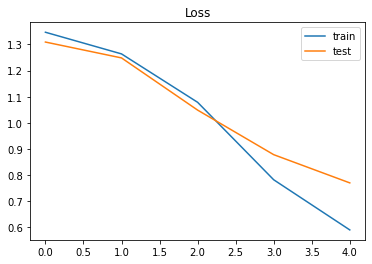

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

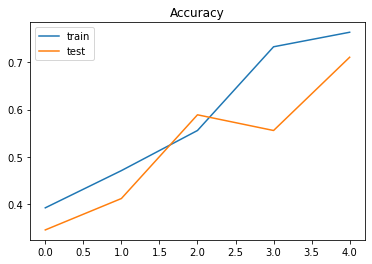

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

Clasifico un nuevo correo:

In [ ]:
#new_complaint = ['Texto del nuevo correo electrónico']
#seq = tokenizer.texts_to_sequences(new_complaint)
#padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
#pred = model.predict(padded)
#labels = ['Clase1', 'Clase2', 'ClaseN']
#print(pred, labels[np.argmax(pred)])